# Adolescent fertility analysis

Notebook to explore and play with data from the United Nations Human Development Project (http://hdr.undp.org). Analysis inspired by chapter 8 found in the Statistics in a Nutshell book.

In [1]:
# Libraries
from scipy import stats
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # very handy to build regression model

%matplotlib inline

# Data import

In [2]:
# Load files:
#   Gender Inequality Index (GII). Source http://hdr.undp.org/en/indicators/68606).
#   Adolescent birth rate (births per 1,000 women ages 15-19). Source: http://hdr.undp.org/en/indicators/36806.
# Set the right encoding = latin
# Ignore first list and the last two ones

GII = pd.read_csv(
    'Gender Inequality Index (GII).csv', 
    encoding='ISO-8859-1',
    skiprows=1,
    skipfooter=2,
    engine='python',
)

adolescent_birth_rate = pd.read_csv(
    'Adolescent birth rate (births per 1,000 women ages 15-19).csv', 
    encoding='ISO-8859-1',
    skiprows=1,
    skipfooter=2,
    engine='python',
)

# Data cleaning

In [3]:
# Show first lines
GII.head()

,HDI Rank,Country,1995,Unnamed: 3,2000,Unnamed: 5,2005,Unnamed: 7,2010,Unnamed: 9,...,2013,Unnamed: 15,2014,Unnamed: 17,2015,Unnamed: 19,2016,Unnamed: 21,2017,Unnamed: 23
0,168,Afghanistan,NaN,NaN,NaN,NaN,0.742,NaN,0.728,NaN,...,0.694,NaN,0.682,NaN,0.672,NaN,0.660,NaN,0.653,NaN
1,68,Albania,NaN,NaN,0.380,NaN,0.329,NaN,0.273,NaN,...,0.267,NaN,0.261,NaN,0.256,NaN,0.250,NaN,0.238,NaN
2,85,Algeria,0.679,a,0.627,NaN,0.561,NaN,0.528,NaN,...,0.432,NaN,0.437,NaN,0.437,NaN,0.432,NaN,0.442,NaN
3,47,Argentina,0.419,a,0.411,NaN,0.372,NaN,0.374,NaN,...,0.365,NaN,0.365,NaN,NaN,NaN,0.361,NaN,0.358,NaN
4,83,Armenia,0.474,a,0.468,NaN,0.403,NaN,0.344,NaN,...,0.312,NaN,0.306,NaN,0.302,NaN,0.296,NaN,0.262,NaN


In [4]:
# Show first lines
adolescent_birth_rate.head()

,HDI Rank,Country,1990,Unnamed: 3,1995,Unnamed: 5,2000,Unnamed: 7,2005,Unnamed: 9,...,2013,Unnamed: 17,2014,Unnamed: 19,2015,Unnamed: 21,2016,Unnamed: 23,2017,Unnamed: 25
0,168,Afghanistan,161.2,NaN,163.9,NaN,165.2,NaN,146.4,NaN,...,85.9,NaN,80.6,NaN,75.3,NaN,64.5,NaN,64.5,a
1,68,Albania,16.3,NaN,18.7,NaN,19.3,NaN,18.8,NaN,...,20.3,NaN,20.5,NaN,20.7,NaN,20.7,NaN,20.7,a
2,85,Algeria,33.1,NaN,24.3,NaN,14.9,NaN,9.7,NaN,...,10.8,NaN,10.8,NaN,10.8,NaN,10.1,NaN,10.1,a
3,147,Angola,220.5,NaN,213.0,NaN,202.5,NaN,192.8,NaN,...,164.7,NaN,161.8,NaN,158.8,NaN,151.6,NaN,151.6,a
4,70,Antigua and Barbuda,83.3,NaN,71.9,NaN,68.7,NaN,62.8,NaN,...,48.8,NaN,47.6,NaN,46.4,NaN,43.5,NaN,43.5,a


We should remove unnamed columns:

In [5]:
def remove_unnamed_columns(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')] # https://stackoverflow.com/a/43983654

GII = remove_unnamed_columns(GII)
adolescent_birth_rate = remove_unnamed_columns(adolescent_birth_rate)

In [6]:
GII.head(5)

,HDI Rank,Country,1995,2000,2005,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,0.742,0.728,0.717,0.706,0.694,0.682,0.672,0.660,0.653
1,68,Albania,NaN,0.380,0.329,0.273,0.276,0.275,0.267,0.261,0.256,0.250,0.238
2,85,Algeria,0.679,0.627,0.561,0.528,0.519,0.436,0.432,0.437,0.437,0.432,0.442
3,47,Argentina,0.419,0.411,0.372,0.374,0.368,0.366,0.365,0.365,NaN,0.361,0.358
4,83,Armenia,0.474,0.468,0.403,0.344,0.339,0.319,0.312,0.306,0.302,0.296,0.262


# Data visualization

To simplify the data visualization, we merge both datasets into one. Let's call them df...

In [7]:
df = GII.merge(adolescent_birth_rate, left_on='Country', right_on='Country', suffixes=('_GII', '_adolescent_birth_rate'))

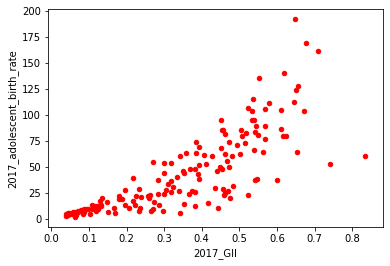

In [8]:
# Analyse correlation between both datasets selecting latest year
df.plot(kind='scatter', x='2017_GII', y='2017_adolescent_birth_rate', color='r')

As we can see the relatinship betweeh the two variables is curvilinear instead of linear.

In [9]:
# Function to test if data follow normal distribution using a Kolmogorov–Smirnov test
def is_data_normal(data, alpha=0.05):
    mean, sd = stats.norm.fit(data) # Try to fit data to a normal distribution if possible
    norm_to_compare = stats.norm(mean, sd) # Create normal distribution with obtained statistics

    ks_result = stats.kstest(data, norm_to_compare.cdf) # Compare data with cumulative distribution function 
    
    return ks_result.pvalue > alpha

Check normality of data, as a requirement to build a regression model:

Is 2017_GII normal?:  True


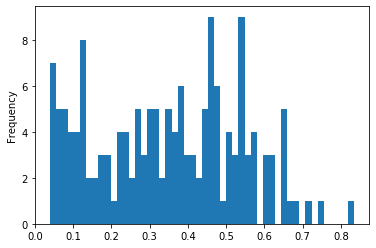

In [10]:
print('Is 2017_GII normal?: ', 
      is_data_normal(df['2017_GII'].dropna())
     )
df['2017_GII'].dropna().plot.hist(bins=50)

Is 2017_adolescent_birth_rate normal?:  False


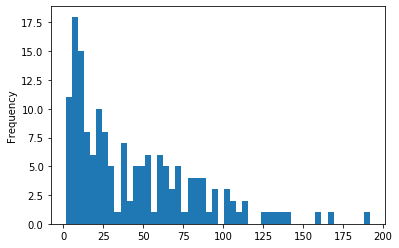

In [11]:
df['2017_adolescent_birth_rate'].plot.hist(bins=50)
print('Is 2017_adolescent_birth_rate normal?: ', 
      is_data_normal(df['2017_adolescent_birth_rate'])
     )

Is natural log of 2017_adolescent_birth_rate normal?:  True


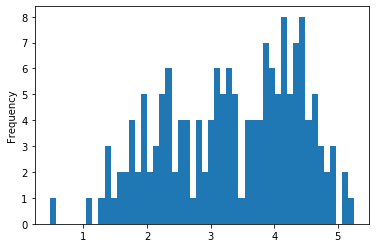

In [12]:
np.log(df['2017_adolescent_birth_rate']).plot.hist(bins=50)
print('Is natural log of 2017_adolescent_birth_rate normal?: ', 
      is_data_normal(np.log(df['2017_adolescent_birth_rate']))
     )

Now, we can check the relationship between the two variables again, but computing the natural log of the adolescent birth rate:

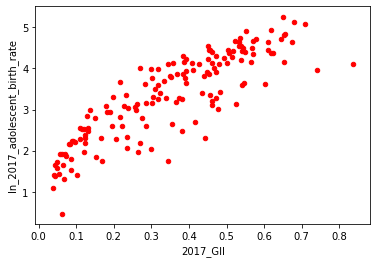

In [13]:
# Analyse correlation between both datasets selecting latest year
df['ln_2017_adolescent_birth_rate'] = np.log(df['2017_adolescent_birth_rate'])
df.plot(kind='scatter', x='2017_GII', y='ln_2017_adolescent_birth_rate', color='r')

# Regression analysis

Our hypohesis is that the adolescent fertiliy is lower in countries where women are treated more equally. To test this hypothesis, we will perform a regression analysis.

The regression model could be:

\begin{align}
\ln(adolescent fertility) & = \beta_{0} + \beta_{1}(GII) + \epsilon
\end{align}

In [14]:
# Select only the columns we are going to use in our analysis
df_regression = df[['2017_GII', 'ln_2017_adolescent_birth_rate']].dropna()

# Model implementation with statsmodels
X = df_regression['2017_GII'].values
y = df_regression['ln_2017_adolescent_birth_rate'].values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)

model = est.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     450.2
Date:                Sun, 25 Aug 2019   Prob (F-statistic):           1.05e-47
Time:                        19:51:17   Log-Likelihood:                -122.51
No. Observations:                 157   AIC:                             249.0
Df Residuals:                     155   BIC:                             255.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6708      0.089     18.840      0.0

The previous summary shows the coeficients that we can use to write the regression equation. Let's build a graph with them:

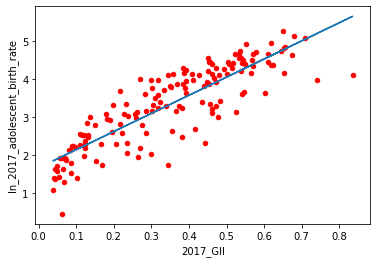

In [15]:
df_regression['regression_GII_birth_rate'] = 1.6708 + 4.7599 * df['2017_GII']

fig, ax = plt.subplots()
df_regression.plot(kind='scatter', x='2017_GII', y='ln_2017_adolescent_birth_rate', color='r', ax=ax)
ax.plot(df_regression['2017_GII'], df_regression['regression_GII_birth_rate'])

Finally, we plot the standardized residuals vs the standardidzed predicted values to check homoscedasticity (variance of the error of the model is constant or not):

In [16]:
influence = model.get_influence()

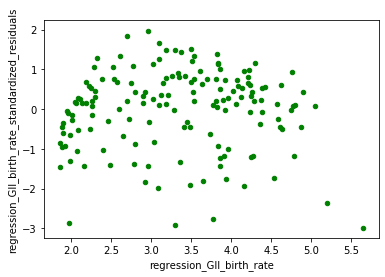

In [17]:
df_regression['regression_GII_birth_rate_standardized_residuals'] = influence.resid_studentized_internal
df_regression.plot(
    kind='scatter', 
    x='regression_GII_birth_rate', 
    y='regression_GII_birth_rate_standardized_residuals', 
    color='g'
)